### Storing the `MovieLens 25M Dataset` to Neo4j

##### Installations

In [13]:
%pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\environ\Scripts\python.exe -m pip install --upgrade pip' command.


#### Imports

In [1]:
import pathlib
import os
from os.path import join
import datetime
from py2neo import Graph, Node, Relationship
from py2neo.bulk import merge_nodes
import pandas as pd

#### Connecting to the neo4j instance

In [2]:
graph = Graph(
    "bolt://localhost:11005",
    auth=("neo4j", "admin"),
)

#### Some helpers fot storing the dataset to `neo4j`

##### General helpers

In [3]:
def read_csv(filename: str):
    db_directory_path = pathlib.Path(os.getcwd()).parent.absolute()
    data_directory_path = join(db_directory_path, "data")
    file_path = join(data_directory_path, f"{filename}.csv")
    print("Reading from:", file_path)
    df = pd.read_csv(file_path)
    return df

def df_to_json(df):
    return df.to_dict("records")

def get_movie_year(movie: Node):
    title = movie["title"]
    try:
        year = int(title[-5:-1])
    except Exception as e:
        print(e)
    return year

def remove_year_from_title(movie: Node):
    try:
        year = get_movie_year(movie)
        return movie["title"].replace(f" ({year})", "")
    except Exception as e:
        print(e)
    return movie["title"]


##### Movies helpers

In [4]:
def insert_movies(movies, limit):
    merge_nodes(
        tx=graph.auto(),
        data=movies[:limit],
        merge_key=("Movie", "title"),
        labels={"Movie"}
    )

def create_attach_genre(movie, relationship, genre_name):
    genre = Node("Genre", name=genre_name)
    genre.__primarylabel__ = "Genre"
    genre.__primarykey__ = "name"
    graph.merge(relationship(movie, genre))

def insert_movie_genres(movie: Node):
    BELONGS_TO = Relationship.type("BELONGS_TO")
    genres = movie["genres"]
    genres_list = genres.split("|") if genres else []
    for genre_name in genres_list:
        create_attach_genre(movie, BELONGS_TO, genre_name)

def insert_movies_genres():
    movies = graph.nodes.match("Movie")
    for movie in movies:
        insert_movie_genres(movie)

def insert_movie_year(movie: Node):
    date = get_movie_year(movie)
    if date:
        PUBLISHED_IN = Relationship.type("PUBLISHED_IN")
        year = Node("Year", date=date)
        year.__primarylabel__ = "Year"
        year.__primarykey__ = "date"
        graph.merge(PUBLISHED_IN(movie, year))

def insert_movies_years():
    movies = graph.nodes.match("Movie")
    for movie in movies:
        insert_movie_year(movie)

def update_movies_titles():
    movies = graph.nodes.match("Movie")
    for movie in movies:
        movie["new_title"] = remove_year_from_title(movie)
        graph.push(movie)


##### Sentiment analysis model to mark tags

In [5]:
# original code from https://towardsdatascience.com/the-most-favorable-pre-trained-sentiment-classifiers-in-python-9107c06442c6

# import the library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# calculate the negative, positive, neutral and compound scores, plus verbal evaluation
def sentiment_vader(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
  
    return {
        "negative": negative,
        "neutral": neutral,
        "positive": positive,
        "compound": compound,
        "overall": overall_sentiment,
    }

##### Users-Ratings-Tags Helpers

In [23]:
def insert_rating(userId: int, movieId: int, rating: float, timestamp: int):
    print("userId:", userId)
    movie = graph.nodes.match("Movie", movieId=movieId).first()
    if movie:
        user = Node("User", userId=userId)
        user.__primarylabel__ = "User"
        user.__primarykey__ = "userId"
        datetime_ = datetime.datetime.fromtimestamp(timestamp)
        print(user, movie, rating, datetime_)
        RATES = Relationship.type("RATES")
        graph.merge(RATES(user, movie, rating=rating, datetime=datetime_))

def insert_ratings(ratings, limit):
    for rating in ratings[:limit]:
        insert_rating(rating["userId"] , rating["movieId"], rating["rating"], rating["timestamp"])

def insert_tag(userId: int, movieId: int, tag: str, timestamp: int):
    movie = graph.nodes.match("Movie", movieId=movieId).first()
    if movie:
        TAGS = Relationship.type("TAGS")
        user = Node("User", userId=userId)
        user.__primarylabel__ = "User"
        user.__primarykey__ = "userId"
        datetime_ = datetime.datetime.fromtimestamp(timestamp)
        sentiment = sentiment_vader(tag)["overall"]
        graph.merge(TAGS(user, movie, tag=tag, datetime=datetime_, sentiment=sentiment))

def insert_tags(tags, limit):
    for tag in tags[:limit]:
        insert_tag(tag["userId"], tag["movieId"], tag["tag"], tag["timestamp"])

#### Storing the movies in the database

* I store the following graph:
    * Nodes:
        * Movie
        * Genre
        * Year
    * Edges:
        * (Movie)-[BELONGS_TO]-(Genre)
        * (Movie)-[PUBLISHED_IN]-(Year)

In [7]:
MOVIES_LIMIT = 300

movies_df = read_csv("movies")
movies = df_to_json(movies_df)

insert_movies(movies, MOVIES_LIMIT)
insert_movies_genres()
insert_movies_years()
update_movies_titles()


Reading from: c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\movies_db\data\movies.csv


##### After storing the first 300 movies in the database

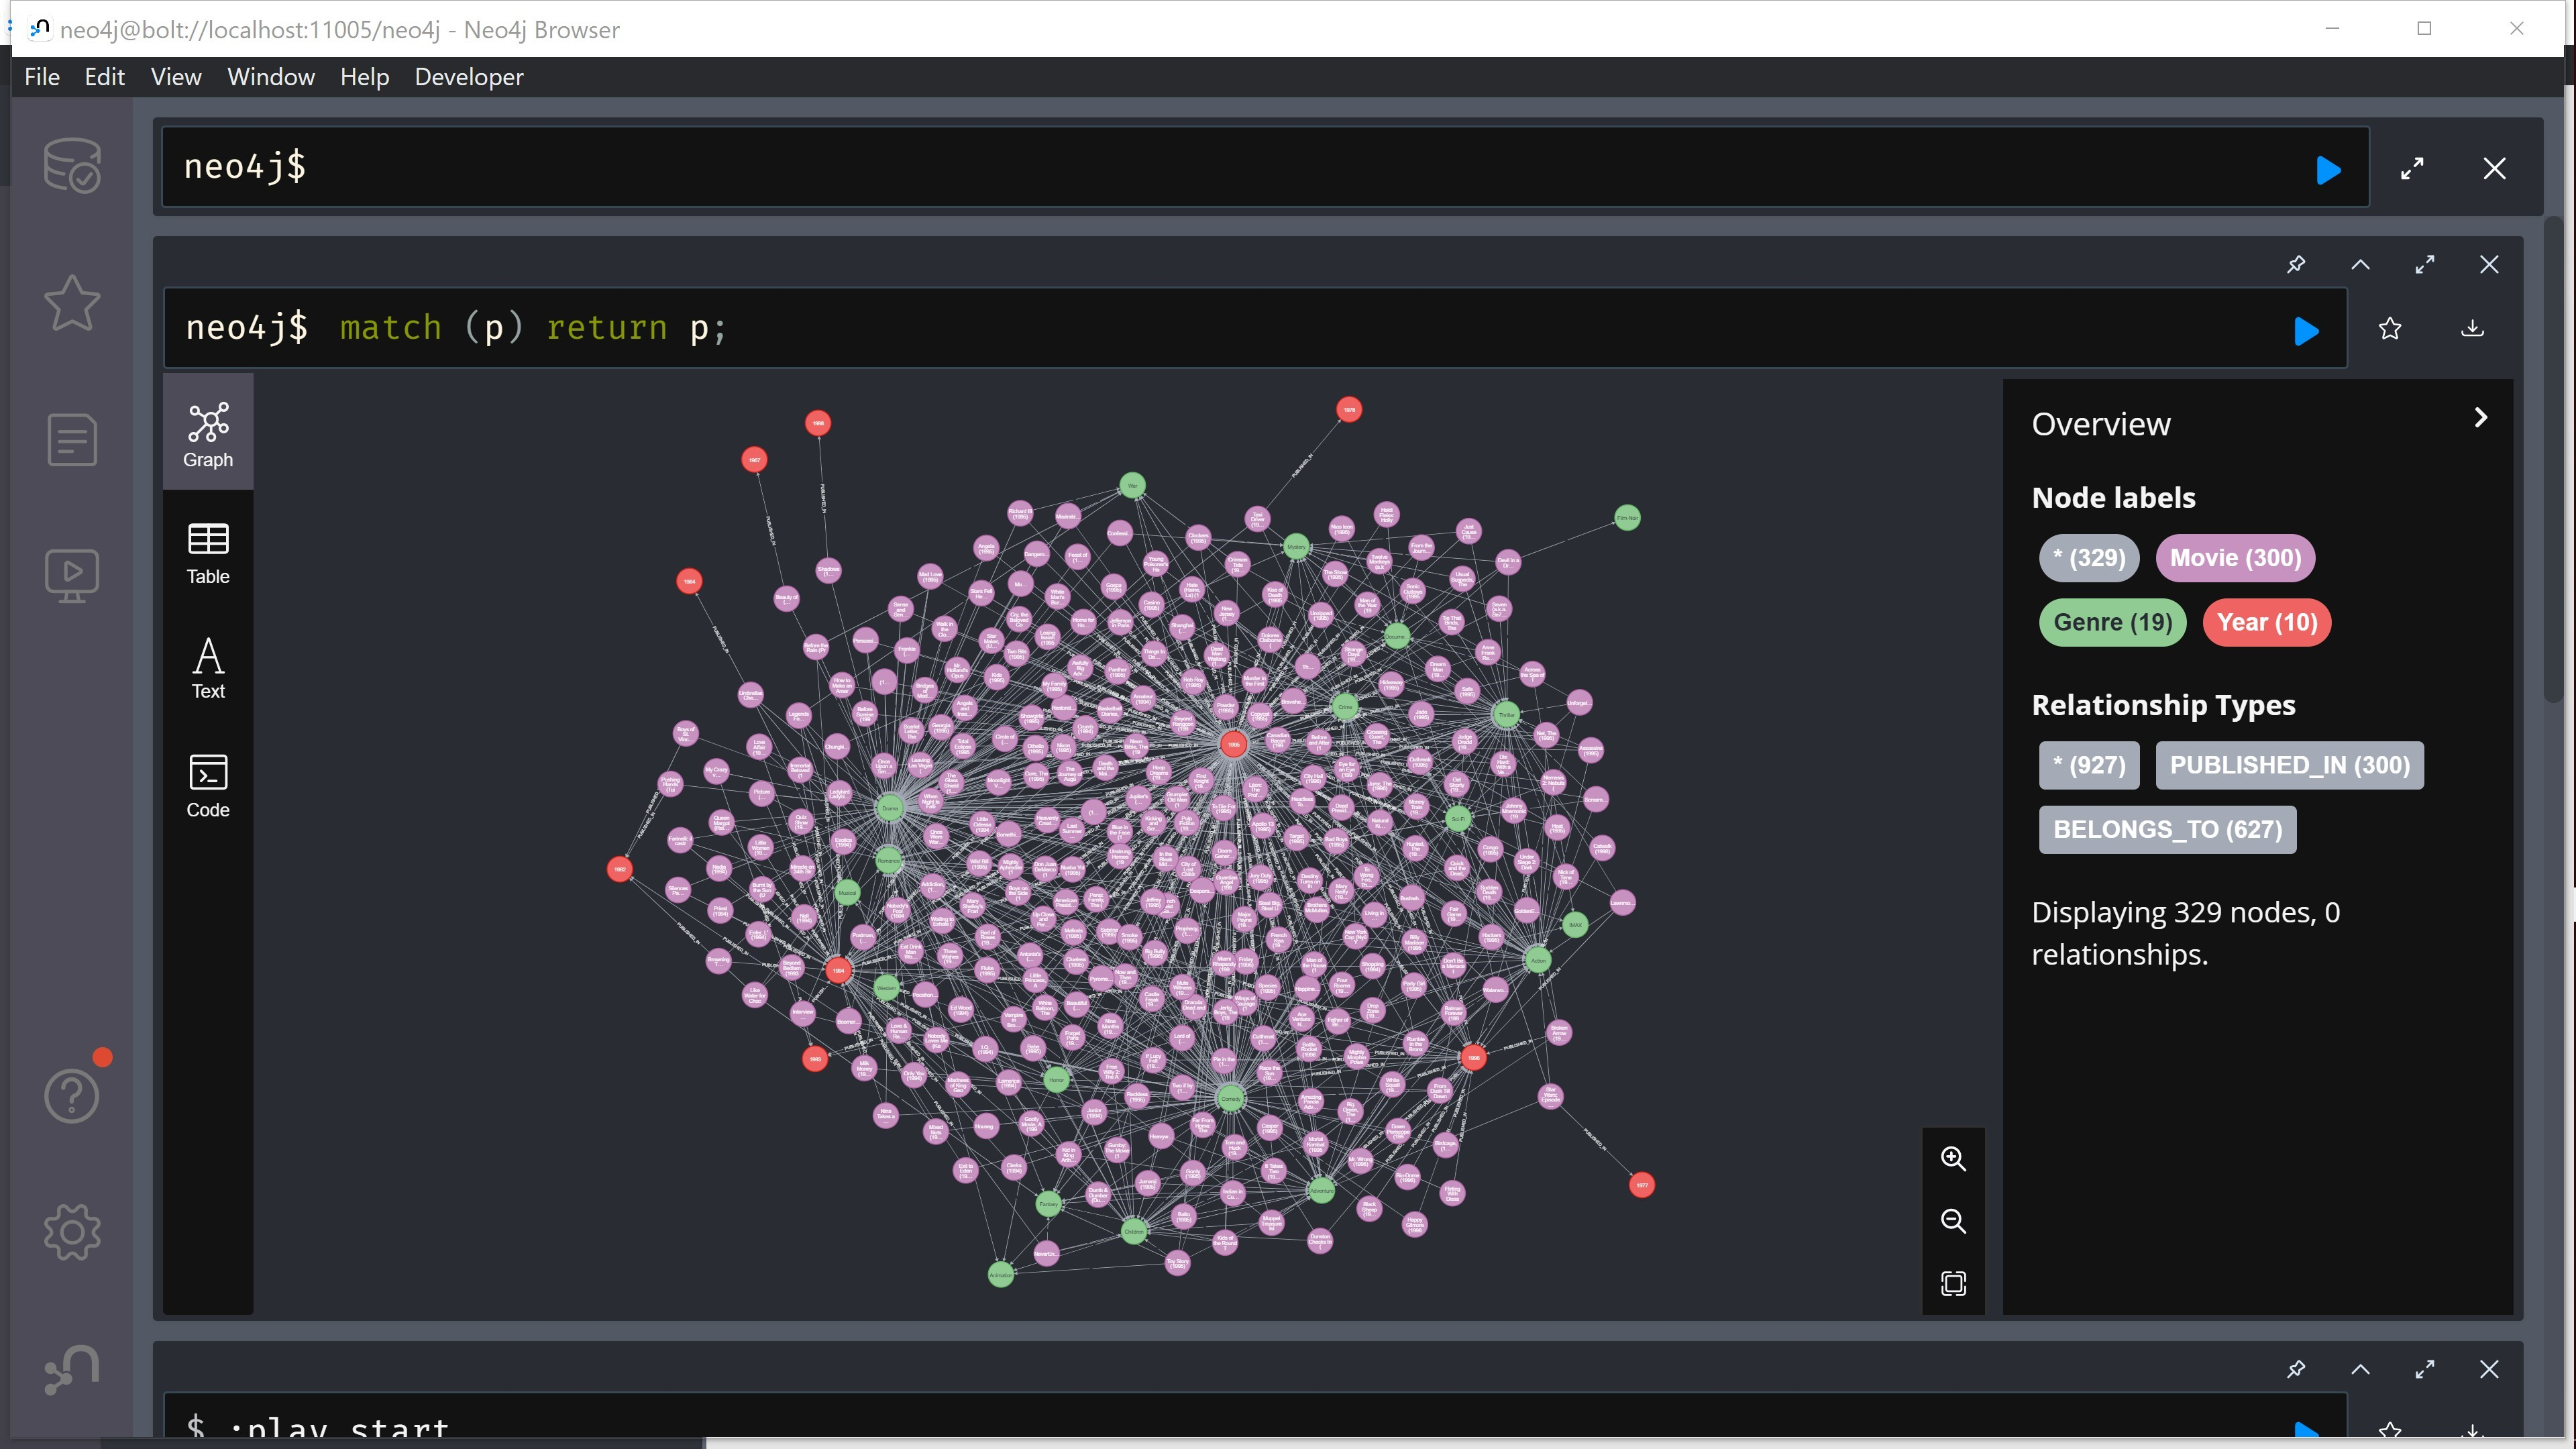

In [8]:
from IPython.display import Image
Image(filename='../images/300_movies.jpg') 

##### Storing the first ratings in the database

In [ ]:
RATINGS_LIMIT = 10000
ratings_df = read_csv("ratings")
ratings = df_to_json(ratings_df)

In [19]:
insert_ratings(ratings, RATINGS_LIMIT)

userId: 1
(:User {userId: 1}) (_34920:Movie {genres: 'Comedy|Crime|Drama|Thriller', movieId: 296, new_title: 'Pulp Fiction', title: 'Pulp Fiction (1994)'}) 5.0 2006-05-17 18:34:04
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 1
userId: 2
(:User {userId: 2}) (_0:Movie {genres: 'Adventure|Animation|Children|Comedy|Fantasy', movieId: 1, new_title: 'Toy Story'

##### After storing the ratings

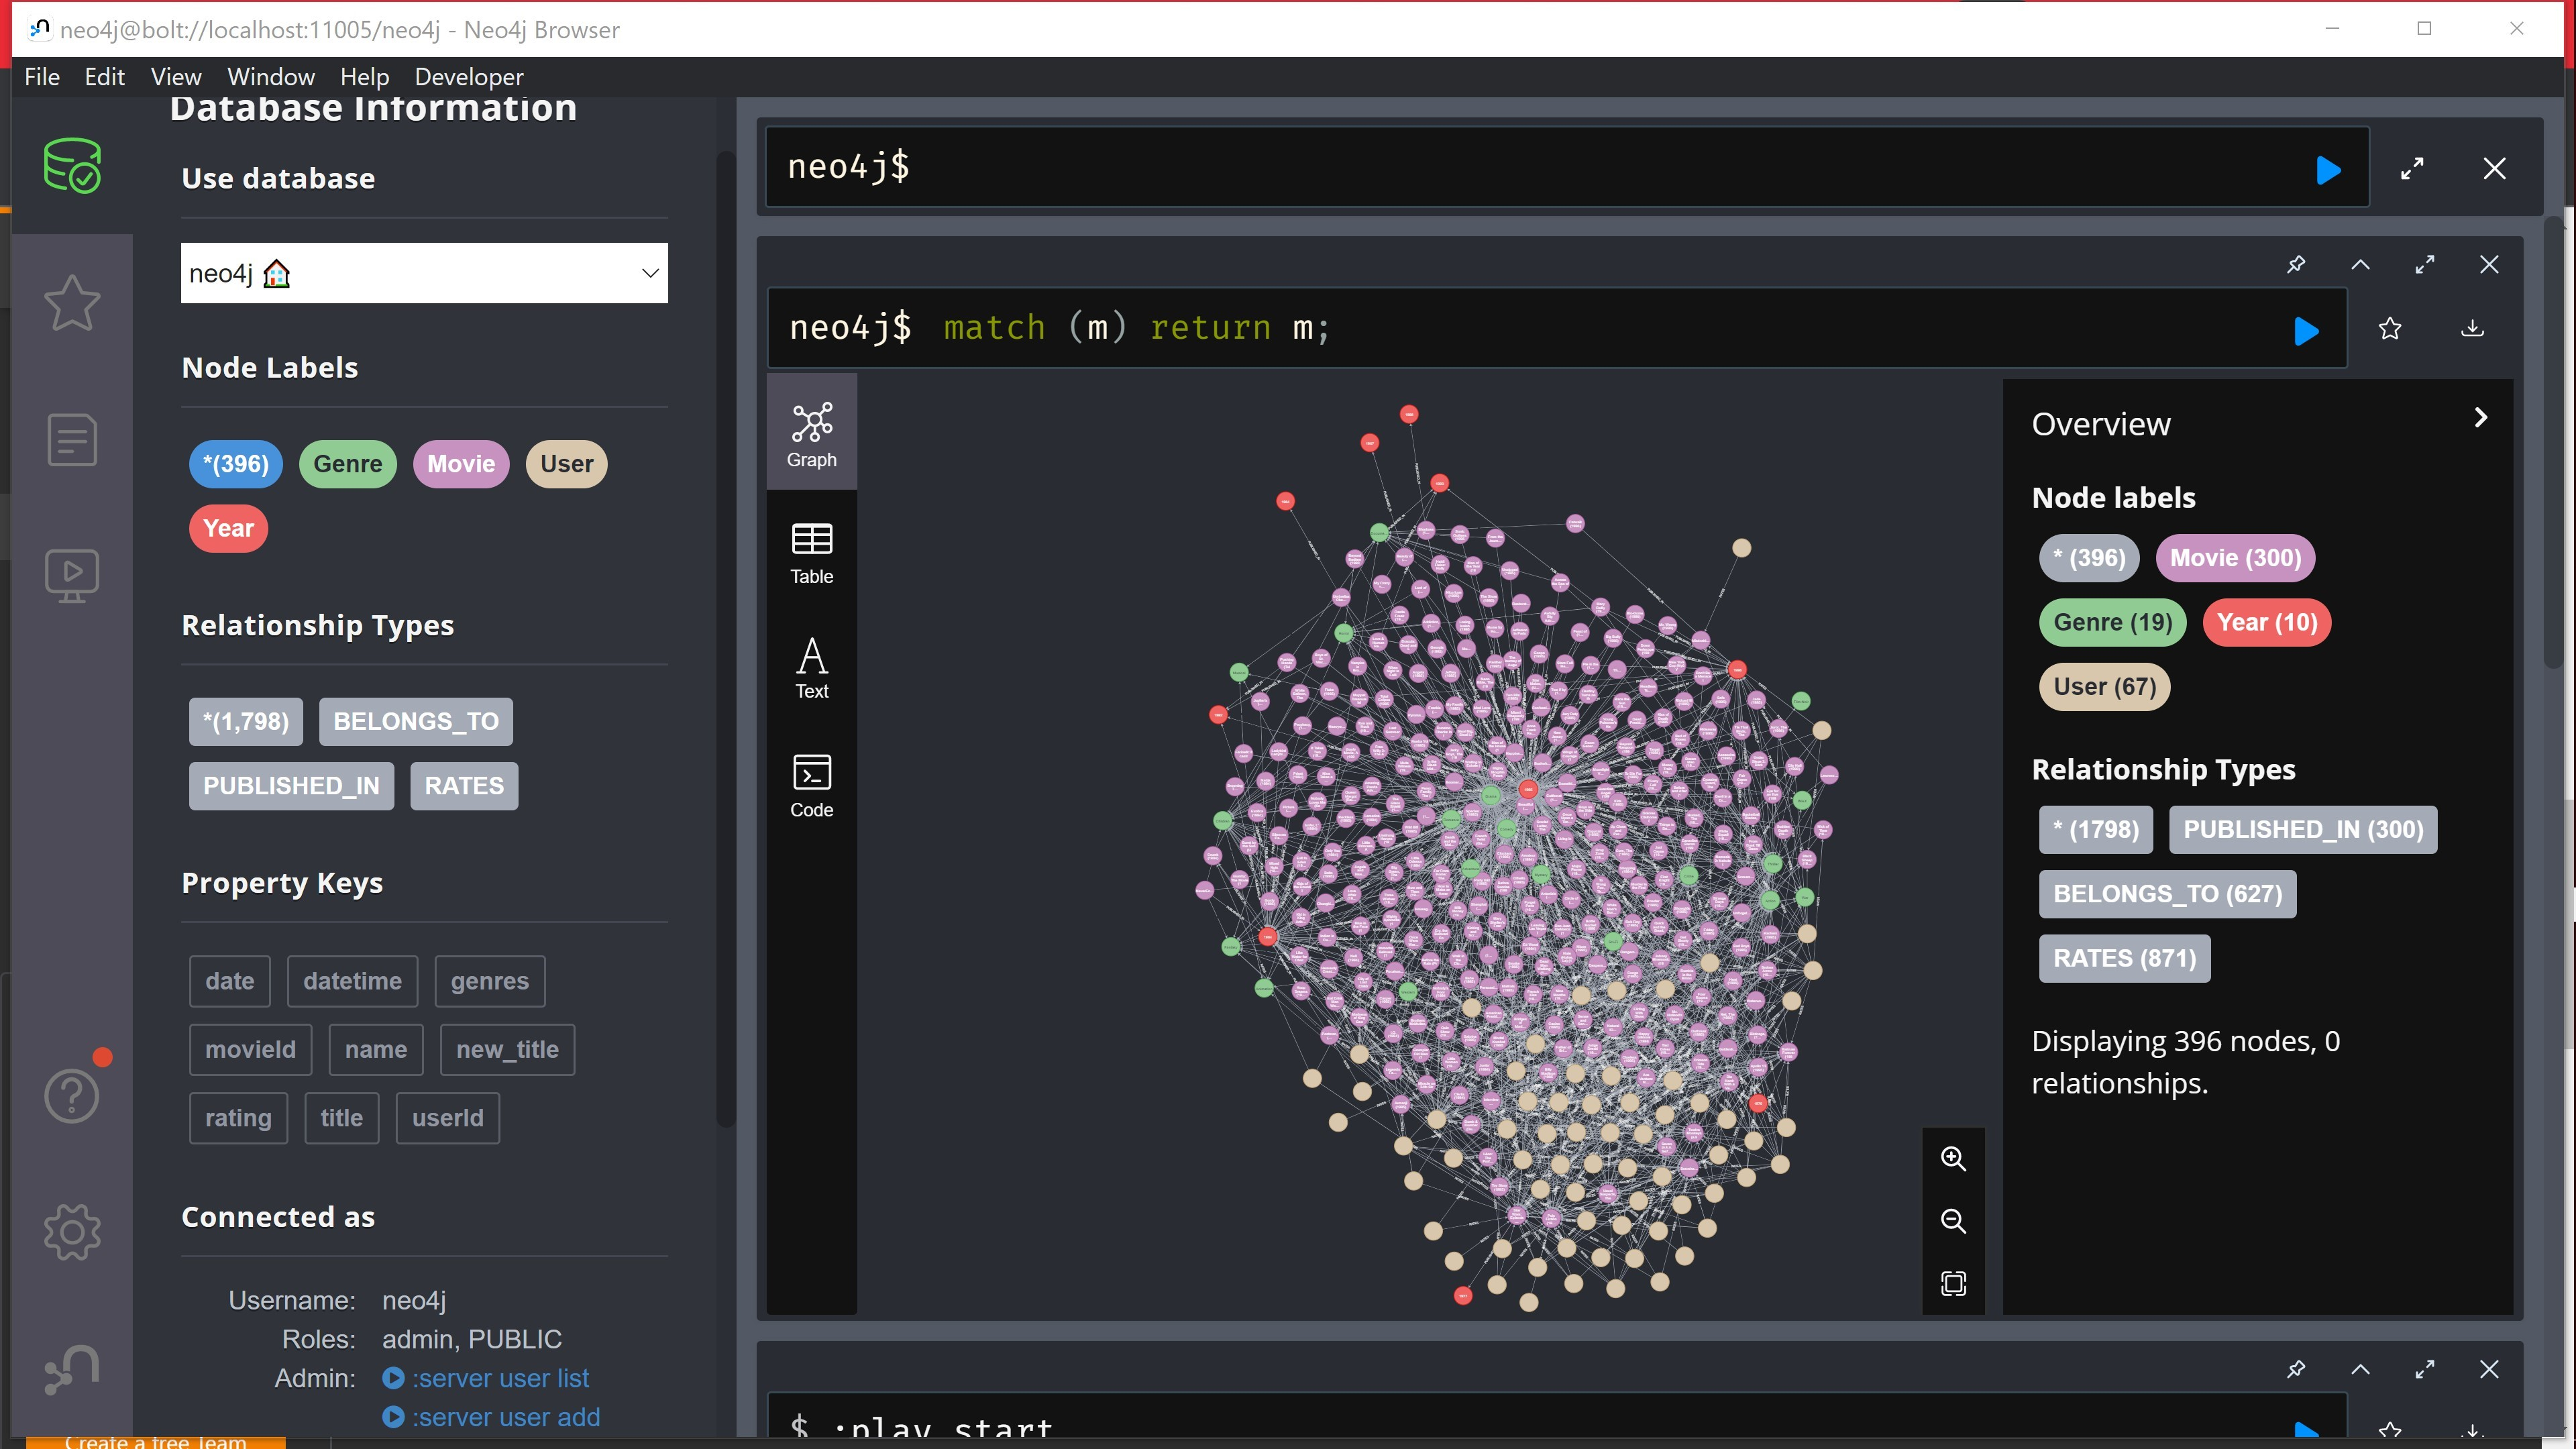

In [25]:
Image(filename='../images/300_movies_10000_ratings.jpg') 

In [21]:
TAGS_LIMIT = 10000
tags_df = read_csv("tags")
tags = df_to_json(tags_df)

Reading from: c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\movies_db\data\tags.csv


In [24]:
insert_tags(tags, TAGS_LIMIT)

##### After storing the tags

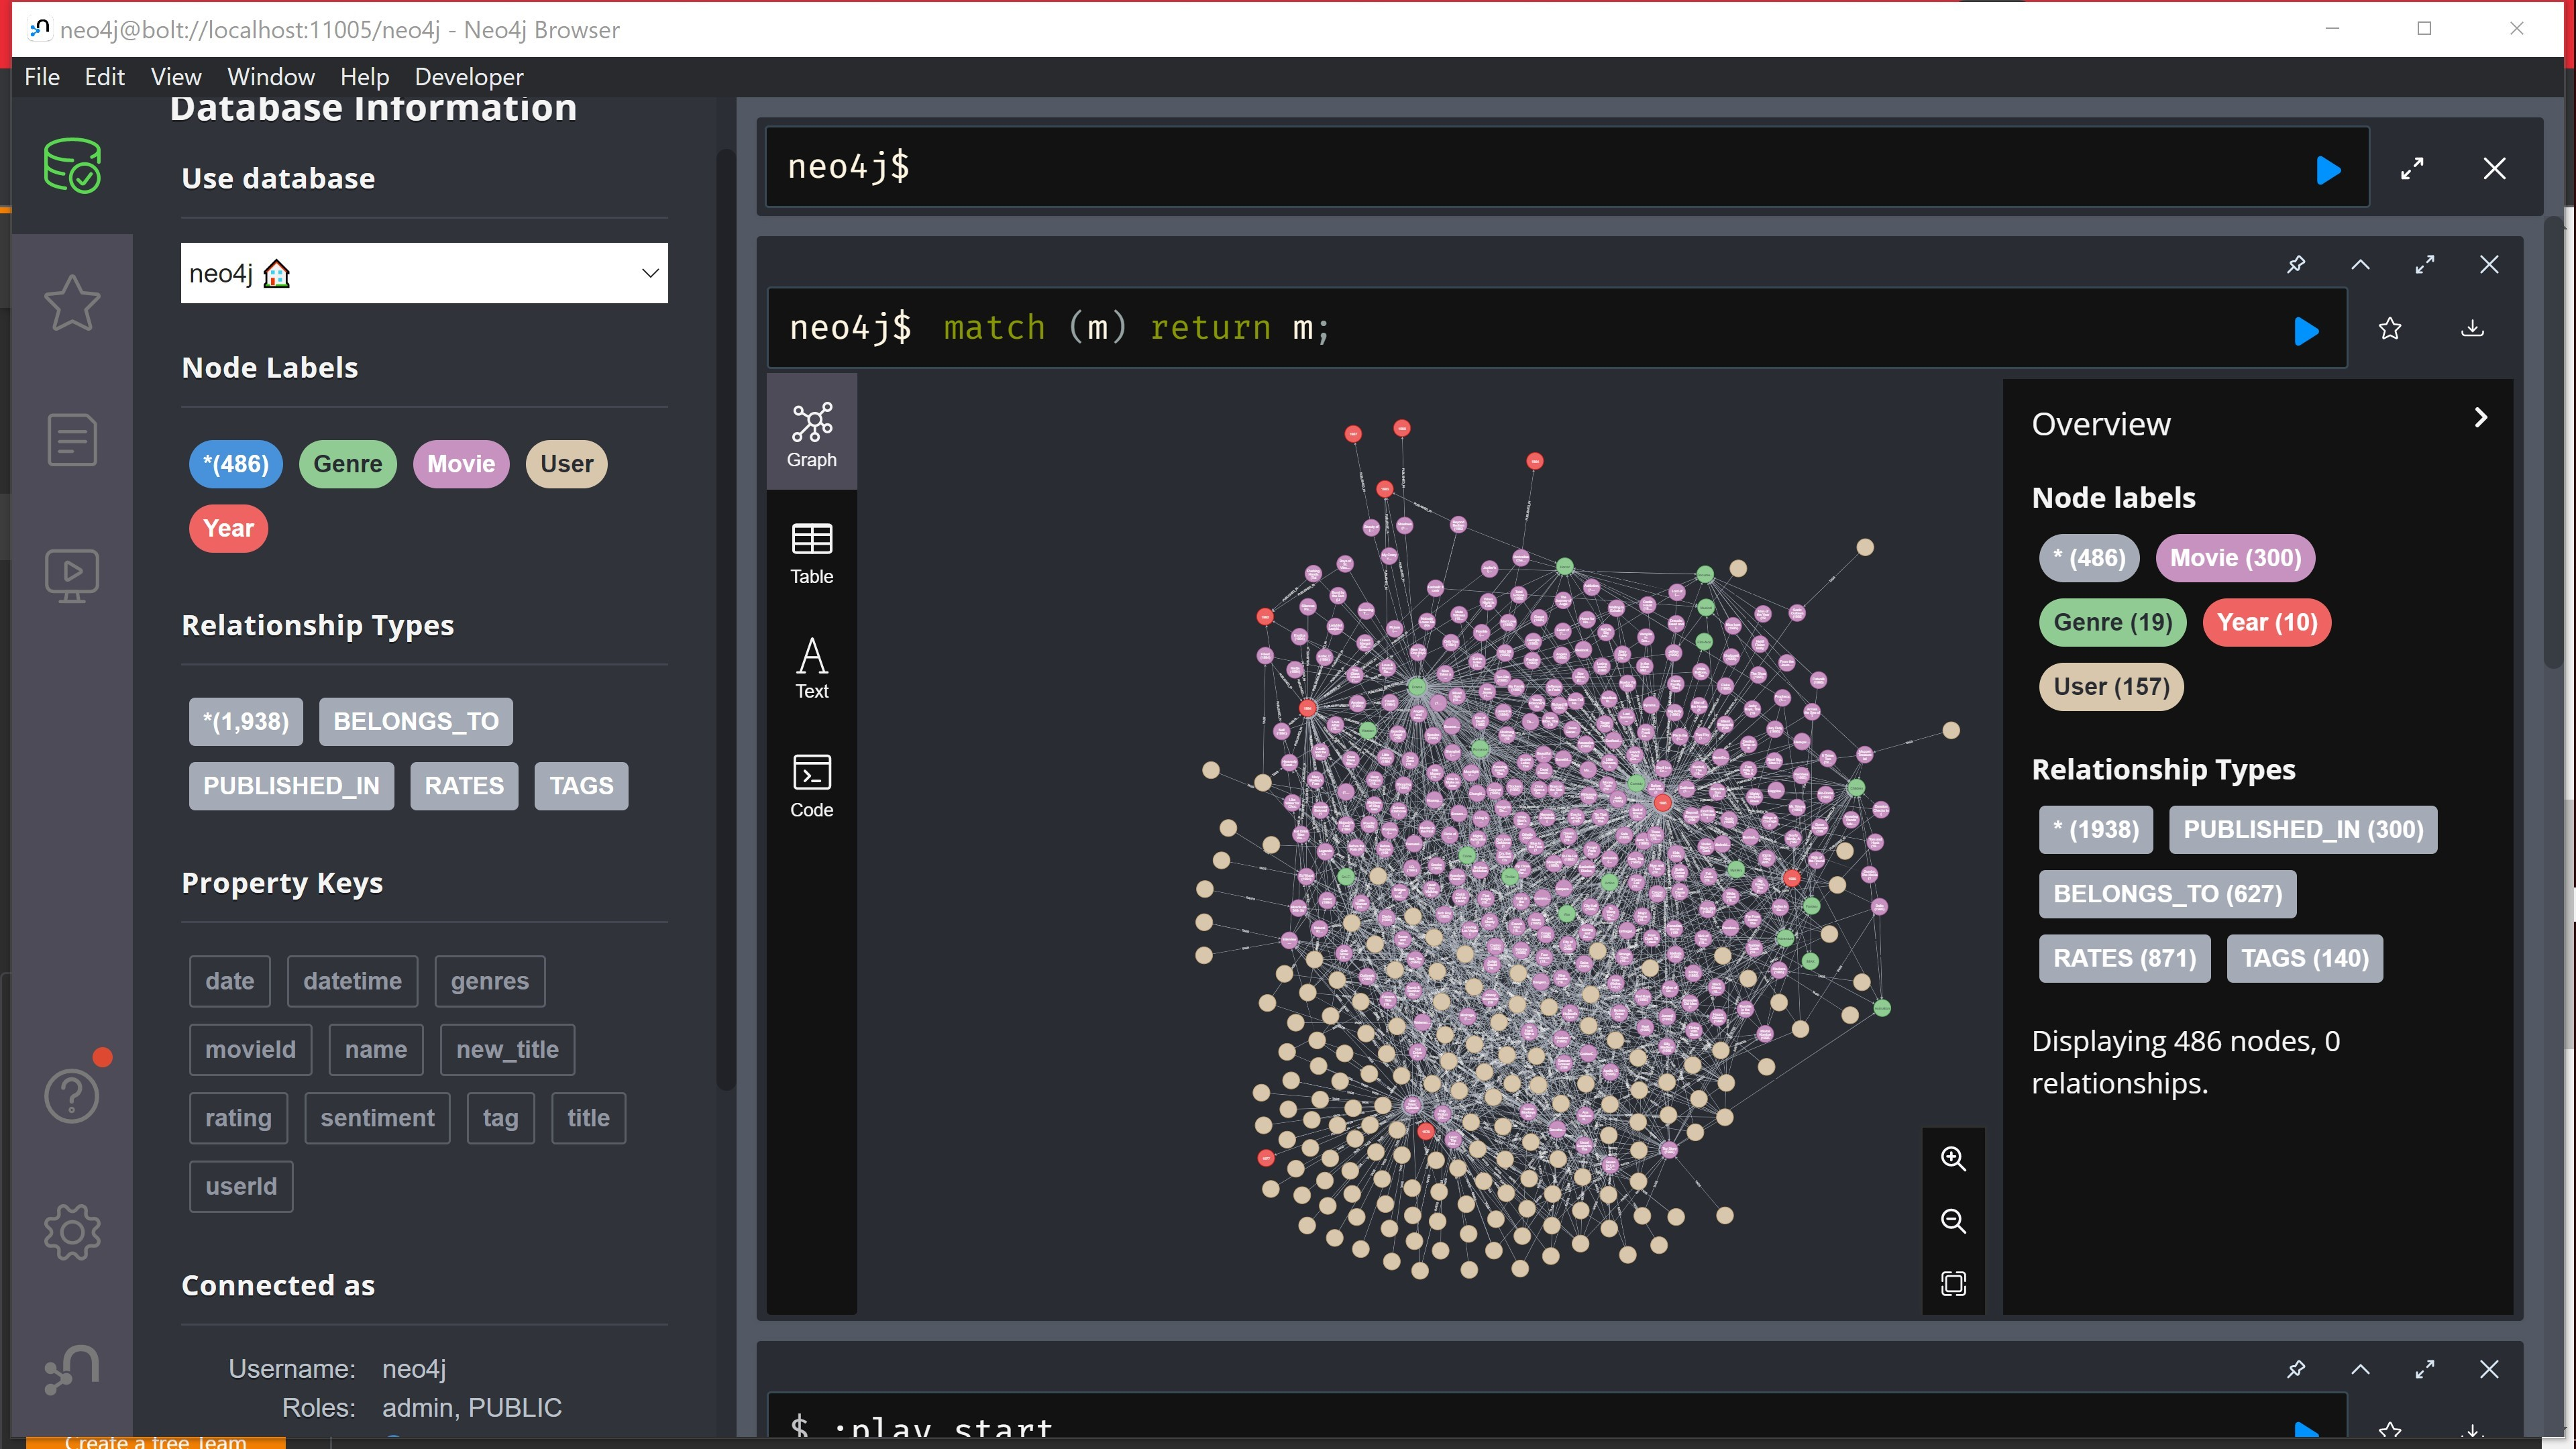

In [26]:
Image(filename='../images/300_movies_10000_ratings_10000_tags.jpg')